In [83]:
from data_fetcher import DataFetcher
from dataset_creator import CustomDataset
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms,utils
import collections

In [9]:
# df = DataFetcher()
# df.createDatabase()

## Data Loading

In [84]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))
])
batch_size = 32


dataset = CustomDataset(root_dir='/Users/wpqbswn/Desktop/Ofek/8200-learning/NadlanCaptchaNumbersClassification/Data', transform=transform)

trainDataset, testDataset = dataset.split_dataset(train_size=0.8, shuffle=True)

trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

torch.Size([32, 4, 224, 224])
              4               8               4               5


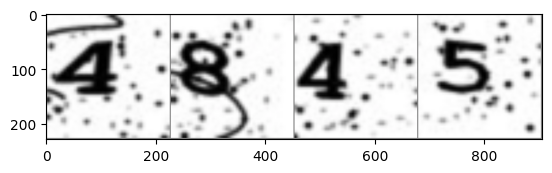

In [85]:
def imshow(img):
    img = img / 2 + 0.5
    imageAsRGBNumpyArray = img.numpy()[:3,:,:]
    plt.imshow(np.transpose(imageAsRGBNumpyArray, (1, 2, 0)))
    
dataiter = iter(trainLoader)
images, labels = next(dataiter)

print(images.shape)

imshow(utils.make_grid(images[:4]))
print(' '.join('%15s' % classes[int(labels[j])] for j in range(4)))

## Data Exploration

In [88]:
number_of_datapoints_in_train_dataset = len(trainDataset)
number_of_datapoints_in_test_dataset = len(testDataset)

number_of_labels_in_train_dataset = max(trainDataset.targets) + 1
number_of_labels_in_test_dataset = max(testDataset.targets) + 1

train_classes = [label for _, label in trainDataset]
samples_per_label_in_train_dataset = collections.Counter(classes)
samples_per_label_in_train_dataset = collections.OrderedDict(sorted(samples_per_label_in_train_dataset.items()))
samples_per_label_in_train_dataset = {classes[index]: number_of_datapoints for index, number_of_datapoints in samples_per_label_in_train_dataset.items()}
test_classes = [label for _, label in testDataset]
samples_per_label_in_test_dataset = collections.Counter(test_classes)
samples_per_label_in_test_dataset = collections.OrderedDict(sorted(samples_per_label_in_test_dataset.items()))
samples_per_label_in_test_dataset = {classes[index]: number_of_datapoints for index, number_of_datapoints in samples_per_label_in_test_dataset.items()}


print('In train_dataset there are:')
print(f'{number_of_datapoints_in_train_dataset} samples,')
print(f'{number_of_labels_in_train_dataset} labels')
print(f'Samples per label:\n{samples_per_label_in_train_dataset}\n')

print('In test_dataset there are:')
print(f'{number_of_datapoints_in_test_dataset} samples,')
print(f'{number_of_labels_in_test_dataset} labels')
print(f'Samples per label:\n{samples_per_label_in_test_dataset}\n')

print(f'train_dataset.__dict__.keys() is: {trainDataset.__dict__.keys()}')

AttributeError: 'Subset' object has no attribute 'targets'

In [81]:
for batch_idx, (data, target) in enumerate(trainLoader):
    print(data.shape)

torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
torch.Size([32, 4, 224, 224])
